In [4]:
%matplotlib inline
import seaborn as sns, numpy as np, cPickle, pandas as pd, pylab,random,cPickle, matplotlib.pyplot as plt
from os import system,listdir
from scipy.cluster.hierarchy import fcluster,linkage,cophenet
from IPython.display import display, HTML
from os.path import join,dirname,basename,isdir
global familymatching_thresh 
from sklearn import decomposition,manifold,preprocessing,metrics
from sklearn.preprocessing import scale,normalize,StandardScaler
from scipy.stats import variation
import matplotlib.cm as cm

topdir = '/cluster/zeng/research/lineage'
familymatching_thresh = 0

#### Run the step 3 and 4 of Indrop pipeline to map the transcripts


```
    cd /cluster/zeng/code/research/lineage/indrops_V2/indrops/
    python run.py 3   (It will instruct you how to qsub the jobs output to a folder)
    python run.py 4
    
```

#### Construct a dictionary that maps droplet-cell barcode to lineage using the results from the above analysis of fth1 barcodes

In [492]:
### Two setup: treat monoallele as a separate lineage, or not.
assignment_files = [join(topdir,'mESC_fth1_timeboth_rep2/post_split/final_lineage_assignment.csv'),\
                      join(topdir,'mESC_fth1_timeboth_rep2/post_split/final_lineage_assignment_allelic.csv') ]
assignment_code = ['','_allelic']
expts = ['mESC_fth1_time1_rep2','mESC_fth1_time2_rep2']
for t_idx,assignment_file in enumerate(assignment_files)
    lineage_assignment = pd.read_csv(assignment_file)
    for expt in expts:
        cellbc2lineage = dict()
        with open(join(topdir,expt,'pre_split/good_barcodes_with_names.pickle'),'rb') as f:
            cellbc2name = cPickle.load(f)
        name2lineagebc = pd.read_csv(join(topdir,expt,'post_split',\
                'cell-lineage_mapping_quality20_mismatch2_prefixsuffixtol2.familyanalysis-cellcentric.thres10.csv'))
        for idx,key in enumerate(cellbc2name.keys()) :
            t_row = name2lineagebc[name2lineagebc['cell']==cellbc2name[key]]['barcodes']
            if len(t_row>0):
                t_barcodes = ','.join(np.sort(t_row.iloc[0].split(',')))
                t_lineage = lineage_assignment[lineage_assignment['Barcodes']==t_barcodes]['Lineage']
                if len(t_lineage) > 0:
                    cellbc2lineage[key] = t_lineage.iloc[0]
                    with open(join(topdir,expt,'post_split','cellbc2lineage'+assignment_code[t_idx]+'.pkl'),'wb') as f:
                        cPickle.dump(cellbc2lineage,f)

#### Take a look the expression data

In [2]:
def loadexpr(datafiles,cellmapper):
    with open(datafiles[0]) as f1,open(datafiles[1]) as f2:
        fulldata_raw = [x.strip().split('\t') for x in f1]
        ambidata_raw = [x.strip().split('\t') for x in f2]
        fulldata = np.asarray([map(float,x[4:]) for x in fulldata_raw[1:]]).transpose()
        ambidata = np.asarray([map(float,x[4:]) for x in ambidata_raw[1:]]).transpose()
        data = fulldata - ambidata
    print 'shape of expression matrix',data.shape
    cells = fulldata_raw[0][4:]
    lineageinfo = ['others' if cellmapper[t_cell]=='NA' else str(cellmapper[t_cell])\
                   for t_idx,t_cell in enumerate(cells)]
    return { 'data':data,'genes':[x[0] for x in fulldata_raw[1:]],'lineageinfo':lineageinfo}

def mynormalizer(data):
    return StandardScaler().fit_transform(normalize(np.log10(data+0.1), axis=1, norm='l1'))

def mynormalizer2(data):
    return StandardScaler().fit_transform(normalize(data, axis=1, norm='l1'))
def mynormalizer3(data):
    return normalize(normalize(np.log10(data+0.1), axis=1, norm='l1'), axis=1, norm='l1')

def mynormalizer4(data):
    return normalize(np.log10(data+0.1), axis=1, norm='l1')

#### Load expression data

In [12]:
expr_data = dict()
for dtype in ['','_allelic']:
    summary = []
    for t_expt_trans in ['mESC_trans_time1_rep2','mESC_trans_time2_rep2']:
        t_expt_fth1 = t_expt_trans.replace('trans','fth1')
        with open(join(topdir,t_expt_trans,'pre_split/good_barcodes_with_names.pickle'),'rb') as f:
            cellbc2name = cPickle.load(f)
        with open(join(topdir,t_expt_fth1,'post_split','cellbc2lineage'+dtype+'.pkl'),'rb') as f:
            cellbc2lineage = cPickle.load(f)
        t_mapper = dict()
        t_table = []
        for idx,key in enumerate(cellbc2name.keys()):
            t_lineage = cellbc2lineage[key] if key in cellbc2lineage.keys() else 'NA'
            t_mapper[cellbc2name[key]] = t_lineage
            t_table.append([cellbc2name[key],t_lineage])
        t_value_cnt = pd.DataFrame(t_table,columns=['name','lineage'])['lineage'].value_counts()
        t_datafiles = [join(topdir,t_expt_trans,'aggregated_counts/full_counts.txt'),\
                            join(topdir,t_expt_trans,'aggregated_counts/ambig_counts.txt')]
        expr_data[t_expt_trans+dtype] = loadexpr(t_datafiles,t_mapper)
        summary += [[t_value_cnt.index[idx],x,t_expt_trans+dtype] for idx,x in enumerate(t_value_cnt)]
    display(pd.pivot_table(pd.DataFrame(summary,columns=['Lineage','cell cnt','Expt']),\
                   values='cell cnt',index='Lineage',columns='Expt'))

shape of expression matrix (635, 28662)
shape of expression matrix (545, 28662)


Expt,mESC_trans_time1_rep2,mESC_trans_time2_rep2
Lineage,,
0,5,9
1,9,3
2,3,NaN
3,15,15
4,3,2
5,5,NaN
6,82,84
7,34,18
8,18,2


shape of expression matrix (635, 28662)
shape of expression matrix (545, 28662)


Expt,mESC_trans_time1_rep2,mESC_trans_time2_rep2
Lineage,,
0,5,9
1,9,3
2,3,NaN
3,12,12
4,3,2
5,NaN,1
6,2,NaN
7,NaN,2
8,1,NaN


#### Cell-centric analysis

Fraction of cells with any gene expression at all 1.0
Fraction of cells with any gene expression at all 1.0


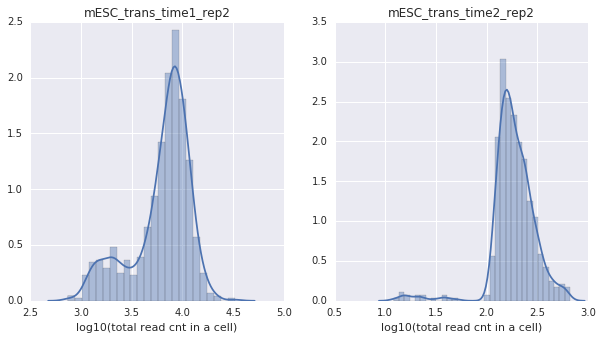

In [6]:
fig, axs = plt.subplots(1, 2,figsize=(10, 5))
for idx,t_expt_trans in enumerate(['mESC_trans_time1_rep2','mESC_trans_time2_rep2']):
    t_cell_cnt = np.sum(expr_data[t_expt_trans]['data'],axis=1)
    g = sns.distplot(pd.Series(np.log10(t_cell_cnt+0.1),name='log10(total read cnt in a cell)'),ax=axs[idx])
    g.set_title(t_expt_trans)
    print 'Fraction of cells with any gene expression at all',len([1 for x in t_cell_cnt if x>0])/float(len(t_cell_cnt))

#### Gene-centric analysis

mESC_trans_time1_rep2
Num of genes 28662
Fraction of gene expressed at all 0.913474286512
mESC_trans_time2_rep2
Num of genes 28662
Fraction of gene expressed at all 0.441699811597


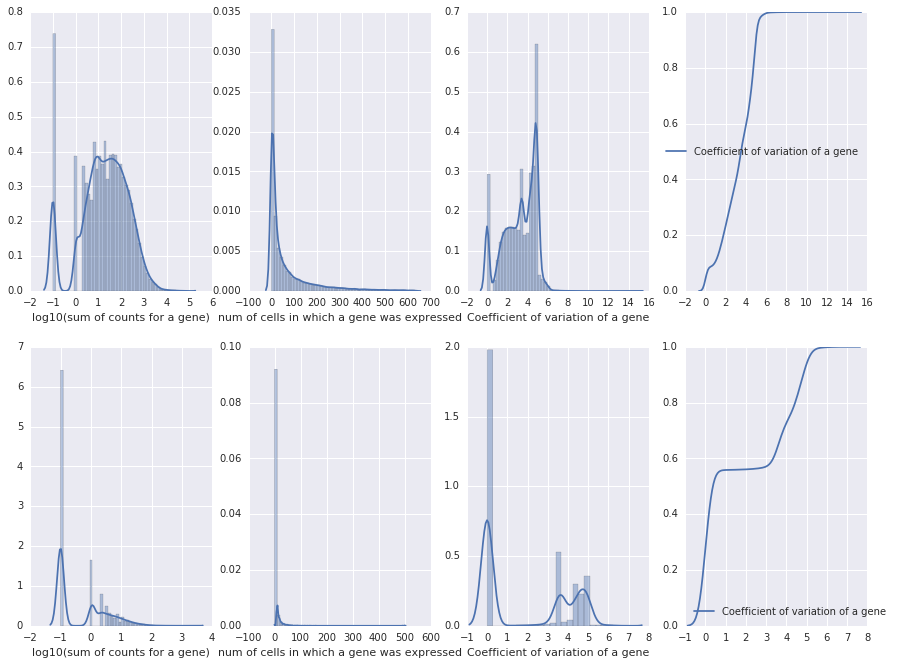

In [7]:
fig, axs = plt.subplots(2, 4,figsize=(15, 11))
myvariation = dict()
mycellexpressed = dict()
for t_idx,t_expt_trans in enumerate(['mESC_trans_time1_rep2','mESC_trans_time2_rep2']):
    print t_expt_trans
    mydata = np.copy(expr_data[t_expt_trans]['data'])
    t_gene_cnt = np.sum(mydata,axis=0)
    print 'Num of genes',len(t_gene_cnt)
    print 'Fraction of gene expressed at all',len([1 for x in t_gene_cnt if x>0])/float(len(t_gene_cnt))
    sns.distplot(pd.Series(np.log10(t_gene_cnt+0.1),name='log10(sum of counts for a gene)'),ax=axs[t_idx][0])

    mycellexpressed[t_expt_trans] = [ np.count_nonzero(x) for x in mydata.transpose()]
    sns.distplot(pd.Series(mycellexpressed[t_expt_trans],\
                           name='num of cells in which a gene was expressed'),ax=axs[t_idx][1])

    for idx,x in enumerate(mydata.transpose()):
        mydata[:,idx] += 0.01
    myvariation[t_expt_trans] = pd.Series(variation(mydata,axis=0),name='Coefficient of variation of a gene')
    sns.distplot(myvariation[t_expt_trans],ax=axs[t_idx][2])
    sns.kdeplot(myvariation[t_expt_trans],cumulative=True,ax=axs[t_idx][3])

#### Data normalization and retain only genes with high CV and read counts

data shape (635, 2089)
data shape (635, 2089)
data shape (545, 483)
data shape (545, 483)


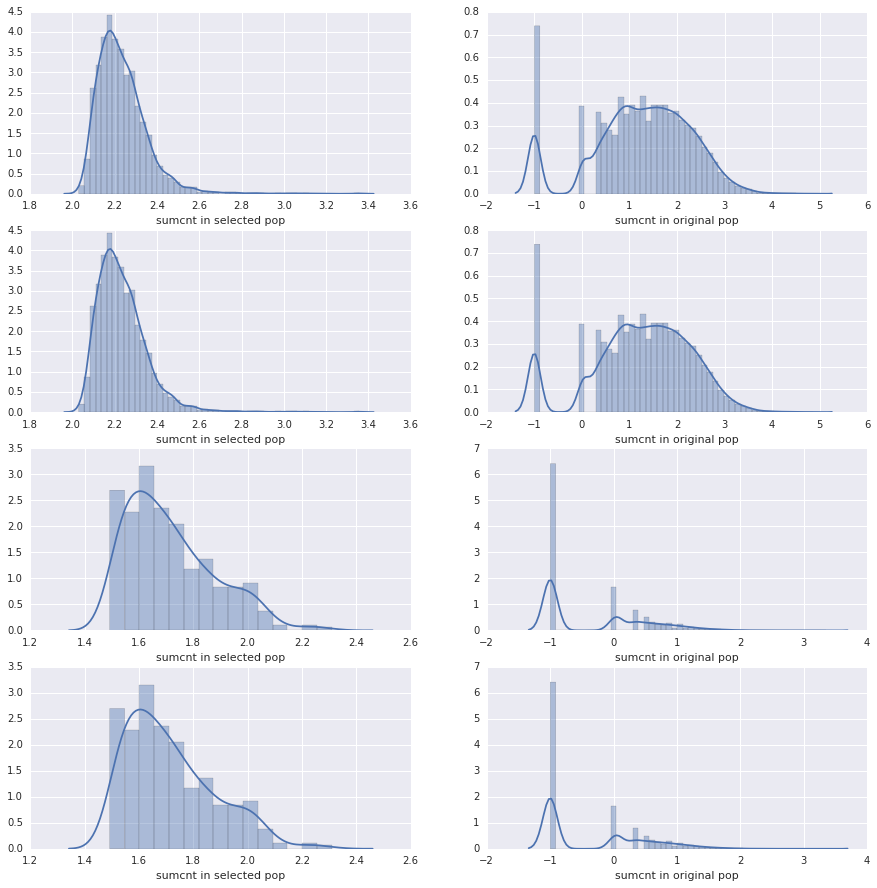

In [20]:
mynormalizer_here = mynormalizer
myCV_cutoff = [2,2]
mycellexpressed_cutoff = [100,30]
fig, axs = plt.subplots(4, 2,figsize=(15, 15))
cnt = 0
for t_idx,t_t_expt_trans in enumerate(['mESC_trans_time1_rep2','mESC_trans_time2_rep2']):
    for dtype in ['','_allelic']:
        t_expt_trans = t_t_expt_trans + dtype
        mydata = expr_data[t_expt_trans]['data'].transpose()
        myreadsum = np.sum(mydata,axis=1)
        filtered_pick =[idx for idx,x in enumerate(mydata) if myvariation[t_t_expt_trans][idx]>myCV_cutoff[t_idx] \
                          and mycellexpressed[t_t_expt_trans][idx]> mycellexpressed_cutoff[t_idx]]

        expr_data_filtered = mydata[filtered_pick].transpose()
        print 'data shape',expr_data_filtered.shape
        expr_data[t_expt_trans+'_top'] =  {'data':expr_data_filtered,\
                                        'data_norm':mynormalizer_here(expr_data_filtered),\
                                        'lineageinfo':expr_data[t_expt_trans]['lineageinfo'],\
                                        'genes':np.asarray(expr_data[t_expt_trans]['genes'])[filtered_pick]}
        mysum = np.log10(np.sum(mydata,axis=1)+0.1)
        sns.distplot( pd.Series([ mysum[x]  for x in filtered_pick],name='sumcnt in selected pop'),ax=axs[cnt][0])
        sns.distplot(pd.Series(mysum,name='sumcnt in original pop'),ax=axs[cnt][1])

        expr_data[t_expt_trans]['data_norm'] = mynormalizer_here(expr_data[t_expt_trans]['data'])
        cnt += 1

#### Save data to pickle

In [18]:
for t_idx,t_expt_trans in enumerate(['mESC_trans_time1_rep2','mESC_trans_time2_rep2']):
    for dtype in ["","_allelic"]:
        for gtype in ["","_top"]:  
            t_code = t_expt_trans+dtype+gtype
            with open('data/exprdata_{}.pkl'.format(t_code),'wb') as f:
                cPickle.dump(expr_data[t_code],f)